# pyTorch Convolutional Neural Networks (CNNs)

<div style="padding: 5px; border: 5px solid #a10000ff;">

**Hinweis:** In den Codezellen sind jeweils einige Codeteile nicht programmiert. Diesen Code müssen Sie ergänzen. Die jeweiligen Stellen sind mit einem Kommentar und dem Keyword **TODO** vermerkt und z.T. Stellen mit ... markiert.

Ausserdem gibt es einige assert Statements. Diese geben einen Fehler aus, sollte etwas bei Ihrer Programmierung nicht korrekt sein.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import random
import PIL.Image as Image


## Hintergrundinformationen zu CNNs

Convolutional Neural Networks (CNNs) sind eine spezielle Art von künstlichen neuronalen Netzwerken, die besonders gut für die Verarbeitung von Bilddaten geeignet sind. Sie bestehen wie andere neuronale Netze aus mehreren Schichten, darunter Convolutional Layers, Pooling Layers und Fully Connected Layers.

- **Convolutional Layers**: Diese Schichten verwenden Filter (auch als Kernel bezeichnet), um Features im Eingabebild zu erkennen. Dies ermöglicht es dem Netzwerk, Muster wie Kanten, Ecken und Texturen zu erkennen.
- **Pooling Layers**: Diese Schichten reduzieren die räumlichen Dimensionen der Daten, indem sie Informationen zusammenfassen. Dies hilft, die Anzahl der Parameter zu reduzieren und die Rechenleistung zu verbessern.
- **Fully Connected Layers**: Diese Schichten verbinden alle Neuronen der vorherigen Schicht mit allen Neuronen der nächsten Schicht. Sie werden oft am Ende eines CNNs verwendet, um die erkannten Features in eine Klassifikation oder Regression umzuwandeln.

In diesem Notebook werden wir die Grundlagen von CNNs in PyTorch kennenlernen und ein einfaches CNN für die Bildklassifikation implementieren.

### Torch vorbereiten

In [2]:
# Wir prüfen ob eine Hardwarebeschleunigung möglich ist und verwenden diese, wenn sie verfügbar ist
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit
print(f"Using {device} device")

Using cpu device


## FER-2013 Dataset vorbereiten, laden und visualisieren

Das FER-2013 Dataset enthält Bilder von Gesichtern, die in verschiedene Emotionen klassifiziert sind. Es ist ein häufig verwendetes Dataset für die Gesichtsemotionserkennung. 
In diesem Abschnitt werden wir das Dataset vorbereiten, laden und einige Beispiele visualisieren.

### Daten laden

In [3]:
data_path = "datasets/FER-2013/"
data_train_path = os.path.join(data_path, "train")
data_test_path = os.path.join(data_path, "test")

In [4]:
train_images = torch.load(os.path.join(data_train_path, "train_images.pt"))
train_labels = torch.load(os.path.join(data_train_path, "train_labels.pt"))
test_images = torch.load(os.path.join(data_test_path, "test_images.pt"))
test_labels = torch.load(os.path.join(data_test_path, "test_labels.pt"))


label_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

reverse_label_mapping = {v: k for k, v in label_mapping.items()}


### Beispielbilder aus dem FER-2013 Dataset visualisieren

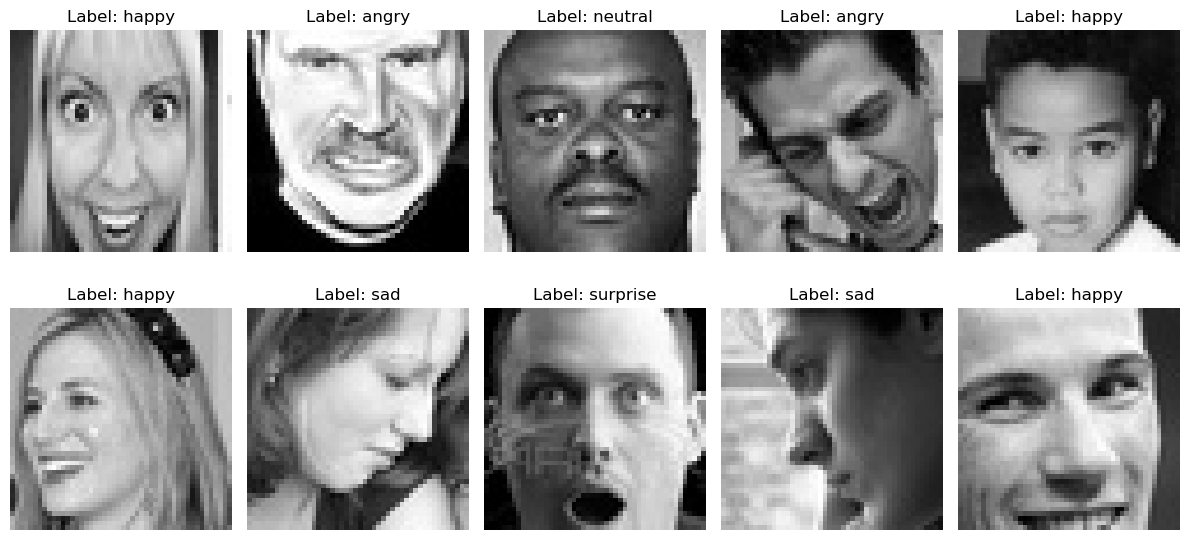

In [5]:
# 10 Beispiele plotten
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    random_index = random.randint(0, len(train_images) - 1)
    ax = axes[i // 5, i % 5]
    ax.imshow(train_images[random_index].squeeze(), cmap='gray')
    ax.set_title(f"Label: {reverse_label_mapping[train_labels[random_index].item()]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


### Daten validieren

Damit wir die Daten benutzen können, müssen alle Daten gleich formiert sein. Das heisst alle Bilder müssen die gleiche Grösse haben und die Pixelwerte müssen im gleichen Bereich liegen.

In diesem Abschnitt prüfen wir, ob es verschiedene Bildgrössen gibt, ob alle Pixelwerte von 0 bis 255 reichen und zeigen ein Beispiel eines Bildes an.

In [7]:
# Die Anzahl Trainings- und Testdaten anzeigen
print(f"Anzahl Trainingsbilder: {len(train_images)}")
print(f"Anzahl Testbilder: {len(test_images)}")

# Prüfe ob alle Bilder die gleiche Größe haben. Die Bilder sind als Tensoren gespeichert, daher können wir die Form der Tensoren überprüfen.
image_shapes = [image.shape for image in train_images]
unique_shapes = set(image_shapes)
print(f"Einzigartige Bildgrößen: {unique_shapes}")


Anzahl Trainingsbilder: 28709
Anzahl Testbilder: 7178
Einzigartige Bildgrößen: {torch.Size([1, 48, 48])}


### Weitere Validierungsschritte

Auch weitere Validierungsschritte sollten durchgeführt werden.

- Sind die Klassen einigermassen gleich verteilt?
- Gibt es fehlende Werte (z.B. auch leere Bilder)?
- Sind auf allen Bildern tatsächlich Gesichter zu sehen?
- Sind die Ausschnitte der Bilder sinnvoll und ähnlich (z.B. alle Bilder zeigen das Gesicht von vorne, oder gibt es auch Bilder von der Seite)?

#### Prüfen der Pixelwerte und Labels

In [8]:
# Prüfen, dass die Pixelwerte im Bereich von 0 bis 255 liegen. Die Bilder sind als Tensoren gespeichert.
# Wir prüfen die Pixelwerte für alle Bilder, indem wir die Werte der Tensoren extrahieren und in eine flache Liste umwandeln.
temp_train_images_np = train_images.numpy()
assert np.all(temp_train_images_np >= 0) and np.all(temp_train_images_np <= 255)

# Labels prüfen
labels = [label.item() for label in train_labels]
print(f"Einzigartige Labels: {set(labels)}")

Einzigartige Labels: {0, 1, 2, 3, 4, 5, 6}


### Data Loader erstellen

In diesem Abschnitt erstellen wir einen Data Loader, um die Daten in Batches zu laden und für das Training vorzubereiten. 
Die Daten sind in Trainings- und Testset aufgeteilt.

In [ ]:
# Da die Bilder in einem eigenen Format vorliegen, normalisieren wir die Pixelwerte manuell, indem wir die Pixelwerte durch 255 teilen, um sie in den Bereich von 0 bis 1 zu bringen. Dies ist wichtig, damit das Training stabiler und schneller lernt.

# Wir müssen hier die Bilder normalisieren, da die Pixelwerte im Bereich 0 bis 255 liegen. Wir teilen die Pixelwerte dementsprechend durch 255.
train_images_tensors = train_images.float() / 255.0
test_images_tensors = test_images.float() / 255.0

# Data Loader erstellen
train_loader = DataLoader(list(zip(train_images_tensors, train_labels)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(test_images_tensors, test_labels)), batch_size=64, shuffle=False)


## Neural Network Architektur definieren

In diesem Abschnitt definieren wir die Architektur unseres Convolutional Neural Networks. 

Wir werden mehrere Convolutional Layers, Pooling Layers und Fully Connected Layers verwenden, um ein Modell zu erstellen, das in der Lage ist, die Bilder im MNIST-Datensatz zu klassifizieren.

### Berechnung der Dimensionen der verschiedenen Layers

In pyTorch müssen wir die Dimensionen der Daten durch die verschiedenen Schichten unseres Netzwerks verfolgen, um die Dimensionen der einzelnen Layers zu konfigurieren.

In diesem Abschnitt berechnen wir die Dimensionen der Daten nach jeder Schicht in unserem CNN.

#### Aufgabe 2

Wir möchten folgende Architektur für unser CNN verwenden:
```
Input (28x28) --> Conv1 (7x7, 12 Filter, Stride 1, Padding 0) --> Pool1 (2x2, Stride 2) --> Conv2 (5x5, 16 Filter, Stride 1, Padding 2) --> Pool2 (2x2, Stride 2) --> Flatten --> Fully Connected Layer
```




1. Berechnen Sie die Bildgrösse nach dem ersten Convolutional Layer:

> Hinweis: Überlegen Sie sich wie sich die Bildgrösse mit dem verwendeten Kernel, Padding und Stride verändert.

> Bildgrösse = 28x28, Kernel Size = 7 , Padding = 0, Stride = 1
> Auf jeder Seite des Bildes vermindert der Kernel die Bildgrösse um 3 Pixel. Da wir kein Padding verwenden und der Stride 1 ist, vermindert sich die Bildgrösse um 6 Pixel (3 Pixel auf jeder Seite).
> Output Size = 22x22

2. Berechnen Sie die Bildgrösse nach dem ersten Pooling Layer:
> Pooling Size = 2x2, Stride = 2 --> Die Pooling-Schicht reduziert die Bildgrösse um die Hälfte, da sie 2x2 Bereiche zusammenfasst und der Stride 2 ist.
> Output Size = 11x11

3. Berechnen Sie die Bildgrösse nach dem zweiten Convolutional Layer:
> Kernel Size = 5, Padding = 2, Stride = 1
> Da wir ein Padding von 2 verwenden und die Kernel-Grösse 5 ist, bleibt die Bildgrösse gleich. --> Output Size = 11x11

4. Berechnen Sie die Bildgrösse nach dem zweiten Pooling Layer:
> Pooling Size = 2x2, Stride = 2 --> Die Pooling-Schicht reduziert die Bildgrösse um die Hälfte, da sie 2x2 Bereiche zusammenfasst und der Stride 2 ist.
> Output Size = 5x5

5. Wie viele Neuronen muss der Fully Connected Layer haben, um die Daten korrekt zu verarbeiten? (Tipp: wir müssen die Anzahl der Kanäle und die Bildgrösse nach dem letzten Pooling Layer berücksichtigen)

> Nach dem zweiten Pooling haben wir 16 Kanäle und die Bildgrösse ist 5x5. Daher müssen wir 16 * 5 * 5 = 400 Neuronen im Fully Connected Layer haben, um alle Informationen aus den vorherigen Schichten zu verarbeiten.


In [ ]:
# TODO erstellen Sie mit torch.nn.sequential ein Convolutional Neural Network mit folgenden Schichten:
# - Convolutional Layer mit einem Eingabe-Kanal, 16 Ausgabekanälen, einem Kernel von 7x7, einem Stride von 1 und einem Padding von 0
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - LeakyRELU Aktivierungsfunktion
# - Convolutional Layer mit 16 Eingabekanälen, 12 Ausgabekanälen, einem Kernel von 5x5, einem Stride von 1 und einem Padding von 2
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - LeakyRELU Aktivierungsfunktion
# - Flatten Layer, um die Daten für den Fully Connected Layer vorzubereiten
# - Fully Connected Layer mit der Anzahl Eingabeneuronen die Sie oben berechnet haben und 10 Ausgabeneuronen.

model_1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=12, kernel_size=5, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=12*8*8, out_features=7),
)

## Netzwerk trainieren und evaluieren
In diesem Abschnitt trainieren wir unser CNN mit dem MNIST-Datensatz und evaluieren die Leistung des Modells auf dem Testset. Wir werden die Trainings- und Testgenauigkeit berechnen und die Ergebnisse visualisieren.

### Trainingloop

Die Funktion `train_model` trainiert das CNN über eine bestimmte Anzahl von Epochen.

Epoch 0: Train Loss = 1.68245, Test Loss = 1.55402
Epoch 1: Train Loss = 1.52481, Test Loss = 1.50991
Epoch 2: Train Loss = 1.46285, Test Loss = 1.46745
Epoch 3: Train Loss = 1.41829, Test Loss = 1.42145
Epoch 4: Train Loss = 1.38340, Test Loss = 1.43038
Epoch 5: Train Loss = 1.35551, Test Loss = 1.38088
Epoch 6: Train Loss = 1.33222, Test Loss = 1.37850
Epoch 7: Train Loss = 1.31320, Test Loss = 1.37319
Epoch 8: Train Loss = 1.29613, Test Loss = 1.35524
Epoch 9: Train Loss = 1.28266, Test Loss = 1.33495
Epoch 10: Train Loss = 1.26714, Test Loss = 1.33994
Epoch 11: Train Loss = 1.25620, Test Loss = 1.33444
Epoch 12: Train Loss = 1.24618, Test Loss = 1.33525
Epoch 13: Train Loss = 1.22888, Test Loss = 1.33447
Epoch 14: Train Loss = 1.21960, Test Loss = 1.32916
Epoch 15: Train Loss = 1.21047, Test Loss = 1.31937
Epoch 16: Train Loss = 1.20274, Test Loss = 1.32945
Epoch 17: Train Loss = 1.19342, Test Loss = 1.31734
Epoch 18: Train Loss = 1.18489, Test Loss = 1.32134
Epoch 19: Train Loss =

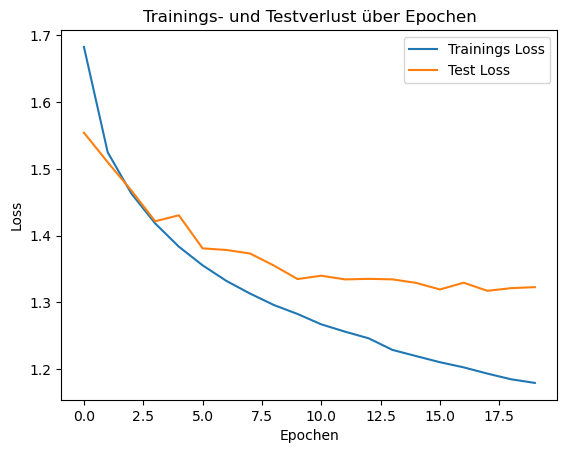

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, loss_fn, max_num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(max_num_epochs):
        batch_train_losses = []
        batch_test_losses = []
        for batch in train_loader:
            images, labels = batch

            # Wir verschieben die Bilder und Labels auf die gleiche Hardware wie das Modell (CPU oder GPU)
            images, labels = images.to(device), labels.to(device)

            # Wir setzen den Gradienten zurück für den Forward- und Backward-Pass
            optimizer.zero_grad()

            # Wir berechnen die Vorhersagen des Modells für die aktuellen Bilder
            outputs = model(images)

            train_loss = loss_fn(outputs, labels)
            train_loss.backward()
            optimizer.step()
            batch_train_losses.append(train_loss.item())

        # Testing Loop mit torch.no_grad(), damit wir keine Gradienten berechnen und somit Speicher sparen
        # Wir berechnen den Testloss für die Testdaten aus dem test_loader
        with torch.no_grad():
            for batch in test_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                batch_test_losses.append(loss(outputs, labels).item())

        training_loss = np.mean(batch_train_losses)
        testing_loss = np.mean(batch_test_losses)
        train_losses.append(training_loss)
        test_losses.append(testing_loss)

        print(f"Epoch {epoch}: Train Loss = {training_loss:.5f}, Test Loss = {testing_loss:.5f}")
    return train_losses, test_losses

### Model Trainieren

In [ ]:
# Hyperparameter definieren
max_num_epochs = 20
learning_rate = 0.001

# Optimizer und die Loss-Funktion definieren
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Das Modell muss noch auf die Hardware verschoben werden.
model_1.to(device)

train_losses, test_losses = train_model(model_1, train_loader, test_loader, optimizer, loss_fn, max_num_epochs)

# Speichern des trainierten Modells
torch.save(model_1.state_dict(), "FER_cnn.pth")

# Test und Trainingsverluste visualisieren
plt.plot(train_losses, label='Trainings Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.title('Trainings- und Testverlust über Epochen')
plt.legend()
plt.show()


### Modell laden

In [ ]:
model_1_geladen = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=12, kernel_size=5, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=12*8*8, out_features=7),
)



# Testen ob das File für das Modell existiert und das Modell geladen werden kann
if os.path.exists("FER_cnn.pth"):
    model_1_geladen.load_state_dict(torch.load("FER_cnn.pth"))
    print("Modell erfolgreich geladen!")


Modell erfolgreich geladen!


### Funktion um die Modell-Accuracy zu berechnen

In [ ]:
# Accuracy berechnen

def test_model_accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

Test Accuracy: 50.32%


In [ ]:
print(f"Test Accuracy: {test_model_accuracy(model_1_geladen, test_loader):.2f}%")

## Alternative Modelle erstellen

### Aufgabe 3: Andere Modelle erstellen und evaluieren

In diesem Abschnitt erstellen Sie zwei weitere Modelle mit unterschiedlichen Architekturen und vergleichen Sie die Leistung dieser Modelle mit dem ursprünglichen Modell.